5b: Add foxes to DaisyWorld

The rate of change of the fox population will like:
$$
\frac{dA_f}{dt} = A_f ( BR_f x - \chi_f)
$$
where $\chi_f$ is the fox death rate, $x_f$ is the fraction of space available to the foxes, and $BR_f$ is the fox birth rate,
$$
BR_f = C_{BR_f} x_f A_r.
$$
The foxes will effect the rabbit population so their population equation becomes,
$$
\frac{dA_r}{dt} = A_r ( BR_r * x_r - \chi_r) - GR_f
$$
where,
$$
GR_f = C_{GR_f} A_r A_f
$$
and,
$$
BR_r = C_{BR_r}(x_r(A_w + A_b)).
$$


The rate of change of the white daisies population is still,
$$
\frac{dA_w}{dt} = A_w ( \beta_w x - \chi) - GR_w
$$

and the rate of change of the black daisies is,
$$
\frac{dA_b}{dt} = A_b ( \beta_b x - \chi) - GR_b
$$

where 
$$
GR_w = C_{GR_r} * A_r * A_w
$$
$$
GR_b = C_{GR_r} * A_r * A_b
$$

$A_f$ = fox population \
$A_r$ = rabbit population \
$A_w, A_b$ = daisie populations \
$BR_f$ = fox birth rate \
$BR_r$ = rabbit birth rate \
$C_{BR_f}, C_{BR_r}$ = fox and rabbit birth rate coefficient \
$GR_f$ = fox grazing rate \
$GR_r$ = rabbit grazing rate \
$C_{GR_f}, C_{GR_r}$ = fox and rabbit grazing rate coefficient \
$x,x_r,x_f$ = fractional space available for each species \
$\chi, \chi_r, \chi_f$ = the death rate of each species 


In [13]:
# functions for problem initial
import context
from numlabs.lab5.lab5_funs import Integrator
import numpy as np
from collections import namedtuple


class RabInteg54(Integrator):
    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc rab_i fox_i'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc, self.initvars.rab_i, self.initvars.fox_i])
        self.nvars = len(self.yinit)
        return None

    def __init__(self, coeff_file_name):
        super().__init__(coeff_file_name)
        self.set_yinit()

    def find_temp(self, yvals):
        """
            Calculate the temperatures over the white and black daisies
            and the planetary equilibrium temperature given the daisy fractions
            
            input:  yvals -- array of dimension [2] with the white [0] and black [1]
                    daisy fractiion
            output:  white temperature (K), black temperature (K), equilibrium temperature (K)
        """
        sigma = 5.67e-8  # Stefan Boltzman constant W/m^2/K^4
        user = self.uservars
        bare = 1.0 - yvals[0] - yvals[1]
        albedo_p = bare * user.albedo_ground + \
            yvals[0] * user.albedo_white + yvals[1] * user.albedo_black
        Te_4 = user.S0 / 4.0 * user.L * (1.0 - albedo_p) / sigma
        temp_e = Te_4**0.25
        eta = user.R * user.L * user.S0 / (4.0 * sigma)
        temp_b = (eta * (albedo_p - user.albedo_black) + Te_4)**0.25
        temp_w = (eta * (albedo_p - user.albedo_white) + Te_4)**0.25
        return (temp_w, temp_b, temp_e)

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           y[2]=initial rabbits
           no feedback between daisies and
           albedo_p (set to ground albedo)
        """
        
        temp_w, temp_b, temp_e = self.find_temp(y)

        if (temp_b >= 277.5 and temp_b <= 312.5):
            beta_b = 1.0 - 0.003265 * (295.0 - temp_b)**2.0
        else:
            beta_b = 0.0

        if (temp_w >= 277.5 and temp_w <= 312.5):
            beta_w = 1.0 - 0.003265 * (295.0 - temp_w)**2.0
        else:
            beta_w = 0.0
        user = self.uservars
        bare = 1.0 - y[0] - y[1]
        
        #beta is the daisie growth rate
        #chi is the daisie death rate
        #bare is the fractional coverage of the daisies

        #rab_i = y[2]
        # rabbits can exist on top of daisies
        barerab = 1.0 - y[2]
        barefox = 1.0 - y[3]

        # fox and rabbit birth rate
        rab_br = user.Crbr * (barerab * (y[0] + y[1]))
        fox_br = user.Cfbr * (barefox * y[2])
        
        # fox and rabbit grazing rate 
        wd_graze = user.Crgr * y[2] * y[0]
        bd_graze = user.Crgr * y[2] * y[1]
        r_graze = user.Cfgr * y[3] * y[2]

        # create a 1 x 2 element vector to hold the derivitive
        # the grazing rate is subtracted from the
        f = np.empty_like(y)
        f[0] = y[0] * (beta_w * bare - user.chi) - wd_graze
        f[1] = y[1] * (beta_b * bare - user.chi) - bd_graze
    
        # add the rabbit population to f
        f[2] = y[2] * (rab_br * barerab - user.rabchi) - r_graze

        # fox population
        f[3] = y[3] * (fox_br * barefox - user.foxchi)
        return f

Black daisie steady state value =  1.7136246851378733e-13


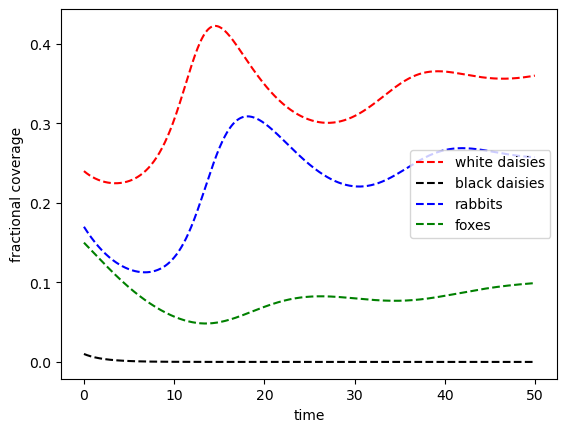

In [26]:
# Solve and plot for problem initial
import matplotlib.pyplot as plt
import pandas as pd

theSolver = RabInteg54('initial-grace1.yaml')
timevals, yvals, errorlist = theSolver.timeloop5fixed()
species = pd.DataFrame(yvals, columns=['white', 'black', 'rabbits', 'foxes'])

thefig, theAx = plt.subplots(1, 1)
line1, = theAx.plot(timevals, species['white'])
line2, = theAx.plot(timevals, species['black'])
line3, = theAx.plot(timevals, species['rabbits'])
line4, = theAx.plot(timevals, species['foxes'])
line1.set(linestyle='--', color='r', label='white daisies')
line2.set(linestyle='--', color='k', label='black daisies')
line3.set(linestyle='--', color='b', label='rabbits')
line4.set(linestyle='--', color='g', label='foxes')
#theAx.set_title('C_rbr = 1, C_rgr = 1, chi_rabbits = 0.3')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
out = theAx.legend(loc='center right')
print('Black daisie steady state value = ', yvals[-1,1])